https://causalnex.readthedocs.io/en/latest/03_tutorial/03_tutorial.html

This tutorial will walk you through an example workflow using CausalNex to estimate whether a student will pass or fail an exam, by looking at various influences like school support, relationship between family members, and others. 

these grades are related with the course subject, Math or Portuguese:
* G1 - first period grade (numeric: from 0 to 20)
* G2 - second period grade (numeric: from 0 to 20)
* G3 - final grade (numeric: from 0 to 20, output target)

## Structure Learning

Defining the structure of a Bayesian Network (BN) model can be done based on machine learning, domain knowledge, or a combination of both, where experts and algorithms contribute as equal partners.

Regardless of the approach, it is important to validate the structure by evaluating the BN - this will be covered later in the tutorial. In this section, we will focus on how to define a structure.

In [2]:
from causalnex.structure import StructureModel
sm = StructureModel()

Next, we can specify the relationships between features. For example, let’s assume that experts tell us the following causal relationships are known (G1 is grade in semester 1): 
* health -> absences 
* health -> G1

In [3]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

## Visualising the Structure

We can examine a StructureModel by looking at the output of sm.edges

In [5]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

but it can often be more intuitive to visualise it. CausalNex provides a plotting module that allows us to do this.

/Users/robincole/.pyenv/versions/3.7.5/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/robincole/.pyenv/versions/3.7.5/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


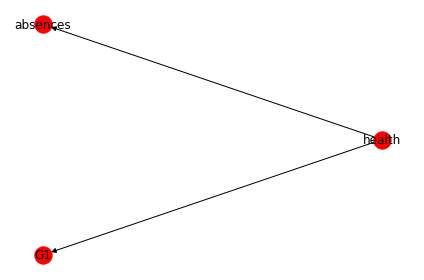

In [6]:
from causalnex.plots import plot_structure

_, _, _ = plot_structure(sm)

## Learning the Structure

As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the NOTEARS algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.


In [7]:
import pandas as pd
data = pd.read_csv('student-por.csv', delimiter=';')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Looking at the data, we can see that features consist of numeric and non-numeric columns. We can drop sensitive features such as sex that we do not want to include in our model.

In [8]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


Next, we want to make our data numeric, since this is what the NOTEARS expects. We can do this by label encoding non-numeric variables.

In [9]:
import numpy as np
struct_data = data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


We can now apply the NOTEARS algorithm to learn the structure.

/Users/robincole/.pyenv/versions/3.7.5/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/robincole/.pyenv/versions/3.7.5/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


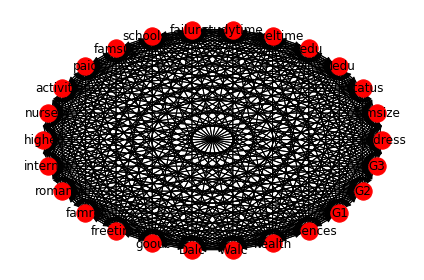

In [11]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(struct_data)
_, _, _ = plot_structure(sm)

The reason why we have a fully connected graph here is we haven’t applied thresholding to the weaker edges. Thresholding can be applied either by specifying the value for the parameter `w_threshold` in `from_pandas`, or we can remove the edges by calling the structure model function, `remove_edges_below_threshold`.

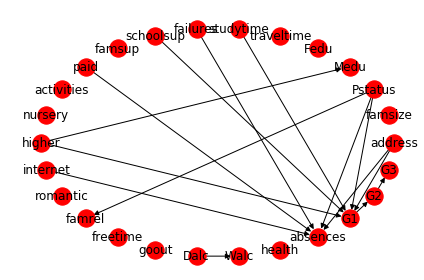

In [12]:
sm.remove_edges_below_threshold(0.8)
_, _, _ = plot_structure(sm)

In this structure, we can see that there are some relationships that appear intuitively correct:

    Pstatus affects famrel - if parents live apart, the quality of family relationship may be poor as a result.
    internet affects absences - The presence of internet at home may cause student to skip class.
    studytime affects G1 - longer studytime should have a positive impact on a student’s result.

However, there are some relationships that are certainly incorrect:

    higher affects Mother’s education - this relationship does not make sense as students who wants to pursue higher education does not affect mother’s education. It could be the other way round.

To avoid these erroneous relationships, we can re-run structure learning with some added constraints:

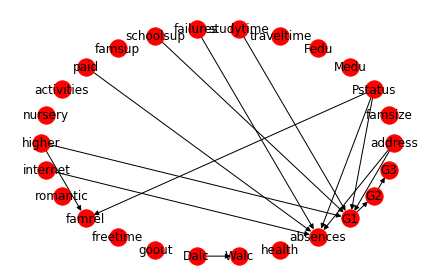

In [14]:
sm = from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)
_, _, _ = plot_structure(sm)

## Modifying the Structure

To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. We can modify the structure model through adding and deleting the edges. For example, we can add and remove edges as:

In [15]:
sm.add_edge("failures", "G1")
sm.remove_edge("Pstatus", "G1")
sm.remove_edge("address", "G1")

We can now visualise our updated structure to confirm it looks reasonable.

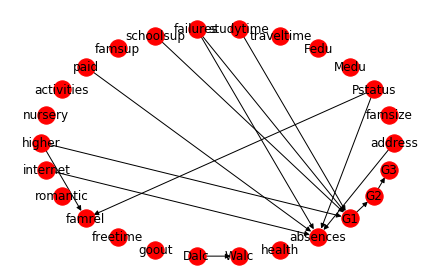

In [16]:
_, _, _ = plot_structure(sm)

We can see there are two separate subgraphs here in the visualisation plot: Dalc->Walc and the other big subgraph. We can retrieve the largest subgraph easily by calling the StructureModel function get_largest_subgraph().

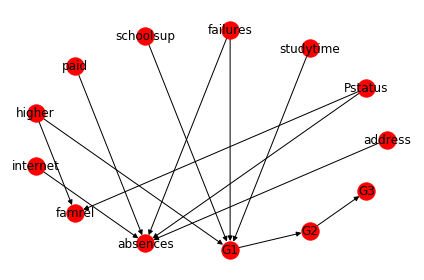

In [17]:
sm = sm.get_largest_subgraph()
_, _, _ = plot_structure(sm)

After deciding on how the final structure model should look, we can instantiate a `BayesianNetwork`.

In [24]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

## Fitting the Conditional Distribution of the Bayesian Network
Preparing the Discretised Data

Bayesian Networks in CausalNex support only discrete distributions. Any continuous features, or features with a large number of categories, should be discretised prior to fitting the Bayesian Network. Models containing variables with many possible values will typically be badly fit, and exhibit poor performance.

For example, consider P(G2 | G1), where G1 and G2 have possible values 0 to 20. The discrete conditional probability distribution is therefore specified using 21x21 (441) possible combinations - most of which we will be unlikely to observe.

CausalNex provides a few helper methods to make discretisation easier. Let’s start by reducing the number of categories in some of the categorical features by combining similar values. We will make numeric features categorical by discretisation, and then give the buckets meaningful labels.
Cardinality of Categorical Features

To reduce the cardinality of categorical features we can define a map `{old_value: new_value}`, and use this to update the feature. For example, in the studytime feature, we make the studytime which is more than 2 (2 means 2 to 5 hours here, see https://archive.ics.uci.edu/ml/datasets/Student+Performance) into long-studytime, and the rest into short-studytime.

In [18]:
discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0]
            else 'have-failure' for v in data_vals['failures']}

studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}

Once we have defined our maps `{old_value: new_value}` we can update each feature, applying the mapping transformation.

In [19]:
discretised_data["failures"] = discretised_data["failures"].map(failures_map)
discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

## Discretising Numeric Features

To make numeric features categorical, they must first be discretised. CausalNex provides a helper class `causalnex.discretiser.Discretiser`, which supports several discretisation methods. For our data the `fixed` method will be applied, providing static values that define the bucket boundaries. For example, `absences` will be discretised into the buckets < 1, 1 to 9, and >=10. Each bucket will be labelled as an integer from zero.

In [20]:
from causalnex.discretiser import Discretiser

discretised_data["absences"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 10]).transform(discretised_data["absences"].values)

discretised_data["G1"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["G1"].values)

discretised_data["G2"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["G2"].values)

discretised_data["G3"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["G3"].values)


## Create Labels for Numeric Features

To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way that we mapped category feature values.

In [21]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

## Train / Test Split

Like many other machine learning models, we will use a train and test split to help us validate our findings.

In [22]:
# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

## Model Probability

With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

In [25]:
bn = bn.fit_node_states(discretised_data)

## Fit Conditional Probability Distributions

The fit_cpds method of BayesianNetwork accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit.

In [26]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

/Users/robincole/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/generic.py:5069: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/robincole/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/generic.py:5070: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


Once we have the the CPDs, we can inspect them through the cpds property, which is a dictionary of node->cpd.

In [27]:
bn.cpds["G1"]

failures    have-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                0.75        0.806452            0.5            0.75   
Pass                0.25        0.193548            0.5            0.25   

failures                                                                 \
higher               yes                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612245            0.5            0.75   
Pass                 0.5        0.387755            0.5            0.25   

failures      no-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612903            0.5             0.5   
Pass                 0.5        0.387097            0.5             0.5   

failures                                                                 
higher               yes                                                 
schoolsup             no                            yes                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
Fail            0.032967         0.15016       0.111111        0.255814  
Pass            0.967033         0.84984       0.888889        0.744186

## Predict the State given the Input Data

The predict method of BayesianNetwork allows us to make predictions based on the data using the learnt Bayesian Network. For example, we want to predict if a student fails or passes their exam based on the input data. Imagine we have an incoming student data that looks like this:

In [28]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short-studytime
failures         have-failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          Low-absence
G2                       Fail
G3                       Fail
Name: 18, dtype: object

Based on these data, we want to predict if this student fails their exam. Intuitively, we would expect this student to fail because they spend a shorter amount of time on their study and have failed in the past. Let’s see how our Bayesian Network performs on this:

In [29]:
predictions = bn.predict(discretised_data, "G1")

In [30]:
print('The prediction is \'{prediction}\''.format(prediction=predictions.loc[18, 'G1_prediction']))

The prediction is 'Fail'


The prediction by the Bayesian Network turns out to be a Fail. Let’s compare this to the ground truth:

In [31]:
print('The ground truth is \'{truth}\''.format(truth=discretised_data.loc[18, 'G1']))

The ground truth is 'Fail'


which turns out to be the same.